In [7]:
import os
import glob
import random
import shutil

# --- Define the paths to your dataset ---
# Make sure to update these paths to where your dataset is located
normal_dir = r'C:\Users\ASHMITH\Desktop\Major_project\chest_xray\train\NORMAL'
pneumonia_dir = r'C:\Users\ASHMITH\Desktop\Major_project\chest_xray\train\PNEUMONIA'

# --- Count the number of images in each class ---
normal_files = glob.glob(os.path.join(normal_dir, '*.jpeg'))
pneumonia_files = glob.glob(os.path.join(pneumonia_dir, '*.jpeg'))

n_normal = len(normal_files)
n_pneumonia = len(pneumonia_files)

print(f"Number of NORMAL images: {n_normal}")
print(f"Number of PNEUMONIA images: {n_pneumonia}")

Number of NORMAL images: 1349
Number of PNEUMONIA images: 3883


In [8]:
# --- Determine the minority and majority classes ---
if n_normal > n_pneumonia:
    majority_files = normal_files
    minority_count = n_pneumonia
    print("NORMAL is the majority class.")
else:
    majority_files = pneumonia_files
    minority_count = n_normal
    print("PNEUMONIA is the majority class.")

# --- Calculate how many files to remove ---
files_to_remove_count = len(majority_files) - minority_count
print(f"Number of files to remove: {files_to_remove_count}")

# --- Randomly select files to delete ---
files_to_remove = random.sample(majority_files, files_to_remove_count)

# --- Delete the selected files ---
for file_path in files_to_remove:
    os.remove(file_path)

print("Undersampling complete. Deleting files...")

# --- Recount the files to confirm ---
normal_files_balanced = glob.glob(os.path.join(normal_dir, '*.jpeg'))
pneumonia_files_balanced = glob.glob(os.path.join(pneumonia_dir, '*.jpeg'))

print(f"New number of NORMAL images: {len(normal_files_balanced)}")
print(f"New number of PNEUMONIA images: {len(pneumonia_files_balanced)}")

PNEUMONIA is the majority class.
Number of files to remove: 2534
Undersampling complete. Deleting files...
New number of NORMAL images: 1349
New number of PNEUMONIA images: 1349


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import numpy as np

# --- Initialize the ImageDataGenerator with desired augmentations ---
# These settings create realistic variations of chest X-rays
datagen = ImageDataGenerator(
    rotation_range=10,        # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,    # Randomly shift images horizontally by 10%
    height_shift_range=0.1,   # Randomly shift images vertically by 10%
    zoom_range=0.1,           # Randomly zoom in on images by 10%
    horizontal_flip=True,     # Randomly flip images horizontally (often not for X-rays, but can be tested)
    brightness_range=[0.9, 1.1], # Randomly change brightness
    fill_mode='nearest'       # Fill in new pixels created by transformations
)

# --- Define the directories to process ---
dirs_to_augment = [normal_dir, pneumonia_dir]
# --- Set the number of augmented images to generate per original image ---
num_augmented_per_image = 5

print("Starting data augmentation...")

for directory in dirs_to_augment:
    all_files = glob.glob(os.path.join(directory, '*.jpeg'))
    print(f"\nProcessing {len(all_files)} images in {directory}...")

    for file_path in all_files:
        # Load the image
        img = load_img(file_path)
        # Convert it to a Numpy array
        x = img_to_array(img)
        # Reshape it to (1, height, width, channels) because the generator expects a batch
        x = np.expand_dims(x, axis=0)

        # Generate augmented images
        i = 0
        # The .flow() command generates batches of randomly transformed images
        # and saves them to the specified directory.
        for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir=directory,
                                  save_prefix=f'aug_{os.path.basename(file_path).split(".")[0]}',
                                  save_format='jpeg'):
            i += 1
            if i >= num_augmented_per_image:
                break  # otherwise the generator would loop indefinitely

print("\nData augmentation complete.")

# --- Final count ---
final_normal_count = len(glob.glob(os.path.join(normal_dir, '*.jpeg')))
final_pneumonia_count = len(glob.glob(os.path.join(pneumonia_dir, '*.jpeg')))

print(f"\nFinal number of NORMAL images: {final_normal_count}")
print(f"Final number of PNEUMONIA images: {final_pneumonia_count}")

Starting data augmentation...

Processing 1349 images in C:\Users\ASHMITH\Desktop\Major_project\chest_xray\train\NORMAL...

Processing 1349 images in C:\Users\ASHMITH\Desktop\Major_project\chest_xray\train\PNEUMONIA...

Data augmentation complete.

Final number of NORMAL images: 8093
Final number of PNEUMONIA images: 8094


In [10]:
import os
import glob
import shutil
import numpy as np

# --- Define paths ---
source_dir_normal = r'C:\Users\ASHMITH\Desktop\Major_project\chest_xray\train\NORMAL'
source_dir_pneumonia = r'C:\Users\ASHMITH\Desktop\Major_project\chest_xray\train\PNEUMONIA'

base_dir = './final_dataset/'

# --- Create directories ---
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

for dir_path in [train_normal_dir, train_pneumonia_dir, val_normal_dir, val_pneumonia_dir, test_normal_dir, test_pneumonia_dir]:
    os.makedirs(dir_path, exist_ok=True)

# --- Function to split and move files ---
def split_data(source_dir, train_dest, val_dest, test_dest, split_ratios=(0.8, 0.1, 0.1)):
    files = np.array(glob.glob(os.path.join(source_dir, '*.jpeg')))
    np.random.shuffle(files)

    train_split = int(len(files) * split_ratios[0])
    val_split = int(len(files) * (split_ratios[0] + split_ratios[1]))

    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]

    for f in train_files:
        shutil.copy(f, train_dest)
    for f in val_files:
        shutil.copy(f, val_dest)
    for f in test_files:
        shutil.copy(f, test_dest)

# --- Run the split for both classes ---
print("Splitting NORMAL files...")
split_data(source_dir_normal, train_normal_dir, val_normal_dir, test_normal_dir)

print("Splitting PNEUMONIA files...")
split_data(source_dir_pneumonia, train_pneumonia_dir, val_pneumonia_dir, test_pneumonia_dir)

print("Data splitting complete.")

Splitting NORMAL files...
Splitting PNEUMONIA files...
Data splitting complete.


In [17]:
import tensorflow as tf

# --- Define image size and batch size ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- Load the data from directories ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary' # For two classes
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# --- Optimize data loading ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Create the model using MobileNetV2 base ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, # Don't include the final classification layer
    weights='imagenet'
)

# Freeze the base model so we only train our new layers
base_model.trainable = False

# --- Add our custom classification layers ---
inputs = tf.keras.Input(shape=(224, 224, 3))
# We need to rescale pixels from [0, 255] to [-1, 1] for MobileNetV2
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # Regularization
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Sigmoid for binary classification

model = tf.keras.Model(inputs, outputs)

model.summary()

Found 12949 files belonging to 2 classes.
Found 1618 files belonging to 2 classes.
Found 1620 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# --- Compile the model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Train the model ---
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 152s 368ms/step - accuracy: 0.7304 - loss: 0.5387 - val_accuracy: 0.8832 - val_loss: 0.3504
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 130s 321ms/step - accuracy: 0.8990 - loss: 0.2994 - val_accuracy: 0.9215 - val_loss: 0.2507
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 130s 322ms/step - accuracy: 0.9216 - loss: 0.2323 - val_accuracy: 0.9308 - val_loss: 0.2091
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 131s 322ms/step - accuracy: 0.9328 - loss: 0.2005 - val_accuracy: 0.9363 - val_loss: 0.1839
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 131s 325ms/step - accuracy: 0.9396 - loss: 0.1792 - val_accuracy: 0.9438 - val_loss: 0.1671
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 132s 325ms/step - accuracy: 0.9425 - loss: 0.1657 - val_accuracy: 0.9468 - val_loss: 0.1554
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 131s 323ms/step - accuracy: 0.9458 - loss: 0.1540 - val_accuracy: 0.9493 - val_loss: 0.1456
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 129s 319ms/step - accuracy: 0.9498 -

In [19]:
# Save the entire model to a single file
model.save('my_pneumonia_model.keras')

print("Model saved successfully!")

Model saved successfully!


51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.9599 - loss: 0.1182
Test Accuracy: 95.99%


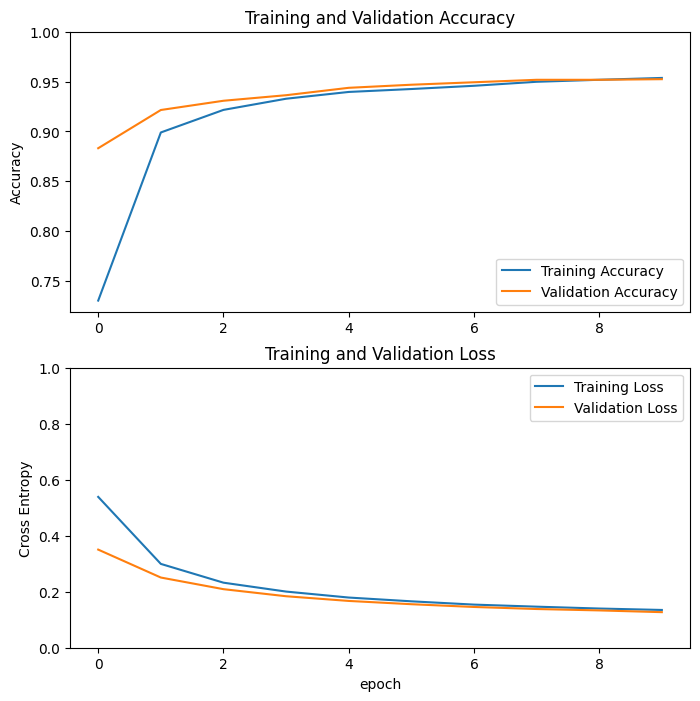

In [24]:
import matplotlib.pyplot as plt

# --- Evaluate on the test set ---
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# --- Plot training history ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

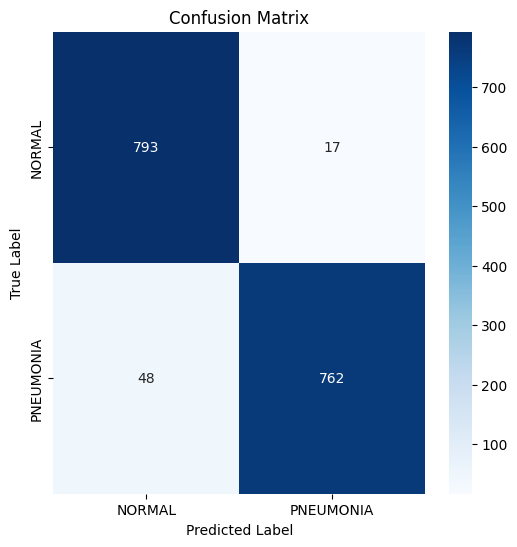


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.98      0.96       810
   PNEUMONIA       0.98      0.94      0.96       810

    accuracy                           0.96      1620
   macro avg       0.96      0.96      0.96      1620
weighted avg       0.96      0.96      0.96      1620



In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- Make predictions on the entire test set ---
y_pred = []
y_true = []
for images, labels in test_ds:
    # The model outputs probabilities, so we round to get 0 or 1
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.round(preds).astype(int).flatten())
    y_true.extend(labels.numpy().astype(int))

# --- Generate the Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- Generate the Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


C:\Users\ASHMITH\AppData\Local\Temp\ipykernel_2212\71250538.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(np.round(prediction))]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


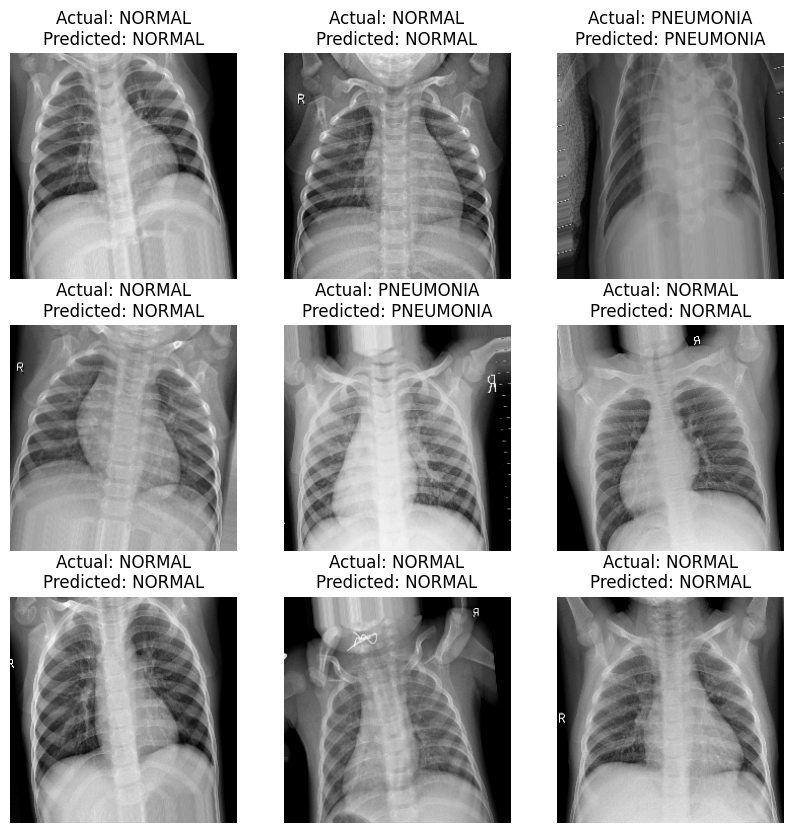

In [27]:
# --- Visualize some predictions from the test set ---
plt.figure(figsize=(10, 10))
class_names = ['NORMAL', 'PNEUMONIA']

# Take one batch from the test dataset
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        prediction = model.predict(tf.expand_dims(images[i], 0))
        predicted_class = class_names[int(np.round(prediction))]
        actual_class = class_names[int(labels[i])]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        plt.axis("off")

In [28]:
# Save the final model
model.save('final_pneumonia_model_95_99_acc.keras')

print("Final model saved successfully!")

Final model saved successfully!
